**Stastical Testing**

### Install libraries for Anova and Wilcoxon

In [109]:
!pip install mlxtend
!pip install pingouin
!pip install statsmodels

In [110]:
#Importing neccessary libraries
import pickle
import calendar
from datetime import datetime
import csv
import os 
import pandas as pd
import numpy as np
from scipy import stats
from mlxtend.evaluate import bootstrap,permutation_test
import seaborn as sns
import matplotlib.pyplot as plt
from pingouin import mixed_anova, read_dataset
from statsmodels.graphics.factorplots import interaction_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Mounting Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Declaring folders and read csv files for processing

In [4]:
#precovid_user_history_folder = '/content/drive/MyDrive/MMT_Project_Data/PreCovidData/hashed_listening_history'
precovid_session_folder = '/content/drive/MyDrive/MMT_Project_Data/PreCovidData/sessions/'
precovid_track_folder = '/content/drive/MyDrive/MMT_Project_Data/PreCovidData/tracks/'

#durcovid_user_history_folder = '/content/drive/MyDrive/MMT_Project_Data/DurCovidData/hashed_listening_history'
durcovid_session_folder = '/content/drive/MyDrive/MMT_Project_Data/DurCovidData/sessions/'
durcovid_track_folder = '/content/drive/MyDrive/MMT_Project_Data/DurCovidData/tracks/'


In [5]:
#Read Files 
user_info = pd.read_csv('/content/drive/MyDrive/MMT_Project_Data/user_info.csv')

precovid_all_user_summary = pd.read_csv('/content/drive/MyDrive/MMT_Project_Data/PreCovidData/all_user_summary.csv')
precovid_user_variability = pd.read_csv('/content/drive/MyDrive/MMT_Project_Data/PreCovidData/all_user_variability.csv') 
precovid_user_autocorr = pd.read_csv('/content/drive/MyDrive/MMT_Project_Data/PreCovidData/all_user_autocorr.csv') 

durcovid_all_user_summary = pd.read_csv('/content/drive/MyDrive/MMT_Project_Data/DurCovidData/all_user_summary.csv')
durcovid_user_variability = pd.read_csv('/content/drive/MyDrive/MMT_Project_Data/DurCovidData/all_user_variability.csv') 
durcovid_user_autocorr = pd.read_csv('/content/drive/MyDrive/MMT_Project_Data/DurCovidData/all_user_autocorr.csv') 



In [29]:
durcovid_all_user_summary.head()

,user_id,K10,total_session,total_tracks,repetitiveness_index,danceability,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,QPS_Q1,QPS_Q2,QPS_Q3,QPS_Q4
0,05157feb07f9e780637ffb96ae549365,38,366,12888,0.310285,0.431723,-9.321963,0.594351,0.082784,0.240250,0.380948,0.213070,120.063777,0.226102,0.476490,0.210583,0.086825
1,06bd850533a713bb7800766860dc6e6e,22,299,4334,0.034181,0.467363,-9.289524,0.720351,0.069420,0.229323,0.139225,0.227184,122.156419,0.388786,0.346101,0.163359,0.101754
2,03e7c2869742ac3b8b04a45675ab5b24,12,316,26177,0.312838,0.496138,-11.763121,0.692555,0.070508,0.536651,0.243316,0.168592,116.045884,0.192192,0.200252,0.493028,0.114528
3,0538da9949fdaa2da6e5f18c0a27e146,30,283,3497,0.051485,0.558748,-8.510295,0.690306,0.097809,0.288765,0.164338,0.193386,123.790945,0.326280,0.369460,0.246783,0.057478
4,03c38064fb423b47d5292bffc09785cc,19,282,3682,0.170458,0.493990,-10.037932,0.640141,0.055906,0.253201,0.247158,0.212354,120.787736,0.356600,0.338946,0.230853,0.073601


In [30]:
feature_columns_with_ri = ['danceability','loudness','mode','speechiness','acousticness','instrumentalness',
           'liveness','tempo','QPS_Q1','QPS_Q2','QPS_Q3','QPS_Q4','total_session','total_tracks','repetitiveness_index']
feature_columns = ['danceability','loudness','mode','speechiness','acousticness','instrumentalness',
           'liveness','tempo','QPS_Q1','QPS_Q2','QPS_Q3','QPS_Q4']

### Separate User for At-Risk and No-Risk

In [7]:
k_10=user_info['K-10']
at_risk_users = user_info[k_10>29]['Your last.fm username'].values
no_risk_users = user_info[k_10<20]['Your last.fm username'].values

In [8]:
print(f'Number of No-Risk users : {len(no_risk_users)}')
print(f'Number of At-Risk users : {len(at_risk_users)}')
print(f'Total Number of users : {len(k_10)}')

Number of No-Risk users : 180
Number of At-Risk users : 120
Total Number of users : 485


### We performed Wilcoxon signed-rank test on features to get relationship between pre-covid and during covid data.

#### For At Risk users

In [31]:
#At Risk
precovid_at_risk_features = precovid_all_user_summary[precovid_all_user_summary['K10']>29]
durcovid_at_risk_features = durcovid_all_user_summary[durcovid_all_user_summary['K10']>29]
all_pvalues = []
for f in feature_columns_with_ri:
    _,p = stats.wilcoxon(precovid_at_risk_features[f],durcovid_at_risk_features[f])
    all_pvalues.append(p)
pd.DataFrame(all_pvalues,columns=['p_value']
             ,index=feature_columns_with_ri)

,p_value
danceability,0.441331
loudness,0.616931
mode,0.731544
speechiness,0.553941
acousticness,0.733515
instrumentalness,0.842236
liveness,0.834050
tempo,0.977018
QPS_Q1,0.402009
QPS_Q2,0.240694


In [20]:
precovid_at_risk_dynamic_aur = precovid_user_autocorr[precovid_user_autocorr['K-10']>29]
durcovid_at_risk_dynamic_aur = durcovid_user_autocorr[durcovid_user_autocorr['K-10']>29]
all_pvalues = []
for f in feature_columns:
    _,p = stats.wilcoxon(precovid_at_risk_dynamic_aur[f],durcovid_at_risk_dynamic_aur[f])
    all_pvalues.append(p)
pd.DataFrame(all_pvalues,columns=['p_value']
             ,index=feature_columns)

,p_value
danceability,0.087243
loudness,0.671379
mode,0.677117
speechiness,0.162757
acousticness,0.271365
instrumentalness,0.216419
liveness,0.947798
tempo,0.866892
QPS_Q1,0.120426
QPS_Q2,0.763285


In [21]:
precovid_at_risk_dynamic = precovid_user_variability[precovid_user_variability['K-10']>29]
durcovid_at_risk_dynamic = durcovid_user_variability[durcovid_user_variability['K-10']>29]
all_pvalues = []
for f in feature_columns:
    _,p = stats.wilcoxon(precovid_at_risk_dynamic[f],durcovid_at_risk_dynamic[f])
    all_pvalues.append(p)
pd.DataFrame(all_pvalues,columns=['p_value']
             ,index=feature_columns)

,p_value
danceability,0.931130
loudness,0.624326
mode,0.180818
speechiness,0.680953
acousticness,0.639229
instrumentalness,0.555697
liveness,0.113099
tempo,0.221325
QPS_Q1,0.189502
QPS_Q2,0.552189


#### For No Risk Users

In [32]:
#No Risk 
precovid_no_risk_features = precovid_all_user_summary[precovid_all_user_summary['K10']<20]
durcovid_no_risk_features = durcovid_all_user_summary[durcovid_all_user_summary['K10']<20]
all_pvalues = []
for f in feature_columns_with_ri:
    _,p = stats.wilcoxon(precovid_no_risk_features[f],durcovid_no_risk_features[f])
    all_pvalues.append(p)
pd.DataFrame(all_pvalues,columns=['p_value']
             ,index=feature_columns_with_ri)

,p_value
danceability,0.346514
loudness,0.184015
mode,0.693387
speechiness,0.863895
acousticness,0.469794
instrumentalness,0.875140
liveness,0.851557
tempo,0.672418
QPS_Q1,0.885282
QPS_Q2,0.416327


In [23]:
precovid_no_risk_dynamic_aur = precovid_user_autocorr[precovid_user_autocorr['K-10']<20]
durcovid_no_risk_dynamic_aur = durcovid_user_autocorr[durcovid_user_autocorr['K-10']<20]
all_pvalues = []
for f in feature_columns:
    _,p = stats.wilcoxon(precovid_no_risk_dynamic_aur[f],durcovid_no_risk_dynamic_aur[f])
    all_pvalues.append(p)
pd.DataFrame(all_pvalues,columns=['p_value']
             ,index=feature_columns)

,p_value
danceability,0.289173
loudness,0.469794
mode,0.053444
speechiness,0.242029
acousticness,0.102519
instrumentalness,0.263351
liveness,0.752233
tempo,0.813665
QPS_Q1,0.280807
QPS_Q2,0.277634


In [24]:
precovid_no_risk_dynamic = precovid_user_variability[precovid_user_variability['K-10']<20]
durcovid_no_risk_dynamic = durcovid_user_variability[durcovid_user_variability['K-10']<20]
all_pvalues = []
for f in feature_columns:
    _,p = stats.wilcoxon(precovid_no_risk_dynamic[f],durcovid_no_risk_dynamic[f])
    all_pvalues.append(p)
pd.DataFrame(all_pvalues,columns=['p_value']
             ,index=feature_columns)

,p_value
danceability,0.327115
loudness,0.311157
mode,0.220333
speechiness,0.944197
acousticness,0.173855
instrumentalness,0.637354
liveness,0.217123
tempo,0.309114
QPS_Q1,0.460194
QPS_Q2,0.193627


#### For All Users

In [33]:
#All 
all_pvalues = []
for f in feature_columns_with_ri:
    _,p = stats.wilcoxon(precovid_all_user_summary[f],durcovid_all_user_summary[f])
    all_pvalues.append(p)
pd.DataFrame(all_pvalues,columns=['p_value']
             ,index=feature_columns_with_ri)

,p_value
danceability,0.562484
loudness,0.087097
mode,0.560519
speechiness,0.825086
acousticness,0.295511
instrumentalness,0.572356
liveness,0.756515
tempo,0.685046
QPS_Q1,0.313348
QPS_Q2,0.100736


In [27]:
all_pvalues = []
for f in feature_columns:
    _,p = stats.wilcoxon(precovid_user_autocorr[f],durcovid_user_autocorr[f])
    all_pvalues.append(p)
pd.DataFrame(all_pvalues,columns=['p_value']
             ,index=feature_columns)

,p_value
danceability,0.063409
loudness,0.702980
mode,0.327062
speechiness,0.066132
acousticness,0.248391
instrumentalness,0.434863
liveness,0.101613
tempo,0.673423
QPS_Q1,0.040845
QPS_Q2,0.262601


In [28]:
all_pvalues = []
for f in feature_columns:
    _,p = stats.wilcoxon(precovid_user_variability[f],durcovid_user_variability[f])
    all_pvalues.append(p)
pd.DataFrame(all_pvalues,columns=['p_value']
             ,index=feature_columns)

,p_value
danceability,0.229290
loudness,0.327382
mode,0.100133
speechiness,0.879670
acousticness,0.062720
instrumentalness,0.243384
liveness,0.018282
tempo,0.141126
QPS_Q1,0.083395
QPS_Q2,0.234219


### Applying Bootstrapping with 1000 iterations to account for Type I error and ensure that the observed differences are not due to chance.

In [52]:
def get_wilcoxon(X):
  x, y = X[0], X[1]
  return stats.wilcoxon(x,y,zero_method='zsplit')[1]

In [53]:
all_pvalues = []
for f in feature_columns:
  x=np.array([precovid_at_risk_features[f],durcovid_at_risk_features[f]])
  original, std_err, ci_bounds = bootstrap(x,num_rounds=1000, func=get_wilcoxon,ci=0.95,
                                         seed=123)
  all_pvalues.append([original,ci_bounds[0],ci_bounds[1]])
  #print(': %.2f, SE: +/- %.2f, CI95: [%.2f, %.2f]' % (original, std_err, ci_bounds[0],ci_bounds[1]))

In [54]:
pd.DataFrame(all_pvalues,columns=['p_value','lower_ci_bounds','upper_ci_bounds']
             ,index=feature_columns)

,p_value,lower_ci_bounds,upper_ci_bounds
danceability,0.441331,0.441331,1.0
loudness,0.616931,0.616931,1.0
mode,0.731544,0.731544,1.0
speechiness,0.553941,0.553941,1.0
acousticness,0.733515,0.733515,1.0
instrumentalness,0.842236,0.842236,1.0
liveness,0.834050,0.834050,1.0
tempo,0.977018,0.977018,1.0
QPS_Q1,0.402009,0.402009,1.0
QPS_Q2,0.240694,0.240694,1.0


### Next we performed Spearman correlations between K10 and all 487 user's number of sessions, total playcount, and RI. 

#### For before covid-19

In [ ]:
#all_user_summary 
stats.spearmanr(precovid_all_user_summary['K10'],precovid_all_user_summary['total_session'])


SpearmanrResult(correlation=0.18950096985657666, pvalue=2.5607715600535423e-05)

In [ ]:
stats.spearmanr(precovid_all_user_summary['K10'],precovid_all_user_summary['total_tracks'])

SpearmanrResult(correlation=0.1345226319932954, pvalue=0.0029341082234932703)

In [ ]:
stats.spearmanr(precovid_all_user_summary['K10'],precovid_all_user_summary['repetitiveness_index'].values)

SpearmanrResult(correlation=0.12472608537669291, pvalue=0.005848409354442624)

#### For during covid-19

In [ ]:
stats.spearmanr(durcovid_all_user_summary['K10'],durcovid_all_user_summary['total_session'])

SpearmanrResult(correlation=0.18540600703581933, pvalue=3.8419224544180334e-05)

In [ ]:
stats.spearmanr(durcovid_all_user_summary['K10'],durcovid_all_user_summary['total_tracks'])

SpearmanrResult(correlation=0.10219781983053836, pvalue=0.024106861922390928)

In [ ]:
stats.spearmanr(durcovid_all_user_summary['K10'],durcovid_all_user_summary['repetitiveness_index'])

SpearmanrResult(correlation=0.14091175060719285, pvalue=0.0018256065509625868)

### Calculating Average value of variability and inertia for all features

In [ ]:
np.sum(precovid_user_variability[feature_columns])/485

danceability         0.102313
loudness             2.734105
mode                 0.235009
speechiness          0.049084
acousticness         0.171806
instrumentalness     0.188558
liveness             0.081291
tempo               14.262486
QPS_Q1               0.241844
QPS_Q2               0.254849
QPS_Q3               0.216209
QPS_Q4               0.099517
dtype: float64

In [ ]:
np.sum(durcovid_user_variability[feature_columns])/485

danceability         0.104388
loudness             2.830155
mode                 0.239680
speechiness          0.049014
acousticness         0.178159
instrumentalness     0.193362
liveness             0.083936
tempo               14.502361
QPS_Q1               0.247967
QPS_Q2               0.257584
QPS_Q3               0.222520
QPS_Q4               0.107513
dtype: float64

### Similarly, correlation between K10 and each of the dynamic measures of audio and emotion features was computed.

#### Pre-Covid 

In [ ]:
rp_list=[]
for f in feature_columns:
  r,p = stats.spearmanr(durcovid_user_autocorr['K-10'],durcovid_user_autocorr[f])
  rp_list.append([r,p])
print(rp_list)

[[0.011120883341200129, 0.8066163968016411], [0.0008540607134761197, 0.9850014141844436], [0.13849151329495088, 0.0021901233766056932], [0.049268425930188736, 0.27786653300387976], [-0.0008991918896174366, 0.9842089436880621], [-0.012438734482303607, 0.7842351438500392], [0.05280389204088128, 0.24478999686416997], [-0.022616958579906875, 0.6185588567461688], [-0.003724829870492861, 0.9346555560769948], [-0.027820718374551374, 0.5402132198982814], [-0.01678874553012734, 0.7117034436075599], [0.004705965368279516, 0.9174984519276441]]


In [ ]:
pd.DataFrame(rp_list,columns=['r','p_value']
             ,index=feature_columns)

,r,p_value
danceability,0.011121,0.806616
loudness,0.000854,0.985001
mode,0.138492,0.002190
speechiness,0.049268,0.277867
acousticness,-0.000899,0.984209
instrumentalness,-0.012439,0.784235
liveness,0.052804,0.244790
tempo,-0.022617,0.618559
QPS_Q1,-0.003725,0.934656
QPS_Q2,-0.027821,0.540213


In [ ]:
rp_list2=[]
for f in feature_columns:
  r,p = stats.spearmanr(precovid_user_variability['K-10'],precovid_user_variability[f])
  rp_list2.append([r,p])
print(rp_list2)

[[-0.04065570144761321, 0.37064933102489594], [-0.0036031627813165328, 0.9367854207933316], [-0.06036029480465202, 0.18357582721867763], [0.044214408981696374, 0.3302076083411237], [0.021614505165955252, 0.6342023438379414], [-0.12587984202711233, 0.005404822085556042], [-0.07006146963979856, 0.12257706405180248], [-0.056713404698279034, 0.21153882105029886], [-0.06580234498819403, 0.1470665035295709], [-0.0645346165226453, 0.155032727321772], [0.023977600524446068, 0.5975995289332934], [0.031151872323207843, 0.4928002903543156]]


In [ ]:
rp=np.concatenate((np.array(rp_list),np.array(rp_list2)),axis=1)

In [ ]:
pd.DataFrame(rp,columns=['r_var','p_var','r_iner','p_iner']
             ,index=feature_columns)

,r_var,p_var,r_iner,p_iner
danceability,0.011121,0.806616,-0.040656,0.370649
loudness,0.000854,0.985001,-0.003603,0.936785
mode,0.138492,0.002190,-0.060360,0.183576
speechiness,0.049268,0.277867,0.044214,0.330208
acousticness,-0.000899,0.984209,0.021615,0.634202
instrumentalness,-0.012439,0.784235,-0.125880,0.005405
liveness,0.052804,0.244790,-0.070061,0.122577
tempo,-0.022617,0.618559,-0.056713,0.211539
QPS_Q1,-0.003725,0.934656,-0.065802,0.147067
QPS_Q2,-0.027821,0.540213,-0.064535,0.155033


### Average Analysis

In [56]:
def get_average_summary(df):
  total_user =len(df['total_session'])
  print(f"Average Number of sessions per user : {np.sum(df['total_session'])/total_user}")
  print(f"Average Number of tracks per user : {np.sum(df['total_tracks'])/total_user}")
  print(f"Average of RepetitivenessIndex per user : {np.sum(df['repetitiveness_index'])/total_user}")

#### All Users

In [57]:
get_average_summary(precovid_all_user_summary)

Average Number of sessions per user : 302.24536082474225
Average Number of tracks per user : 6928.878350515464
Average of RepetitivenessIndex per user : 0.2800412836992624


In [58]:
get_average_summary(durcovid_all_user_summary)

Average Number of sessions per user : 290.4989690721649
Average Number of tracks per user : 7130.79587628866
Average of RepetitivenessIndex per user : 0.29263979020204806


#### No Risk and At Risk

In [59]:
dur_summary_no_risk = durcovid_all_user_summary[durcovid_all_user_summary['K10']<20]
dur_summary_at_risk = durcovid_all_user_summary[durcovid_all_user_summary['K10']>29]
pre_summary_no_risk = precovid_all_user_summary[precovid_all_user_summary['K10']<20]
pre_summary_at_risk = precovid_all_user_summary[precovid_all_user_summary['K10']>29]

In [60]:
get_average_summary(dur_summary_no_risk)

Average Number of sessions per user : 271.9611111111111
Average Number of tracks per user : 6619.811111111111
Average of RepetitivenessIndex per user : 0.25368263229636534


In [61]:
get_average_summary(pre_summary_no_risk)

Average Number of sessions per user : 281.2388888888889
Average Number of tracks per user : 6635.8
Average of RepetitivenessIndex per user : 0.22198648657636053


In [62]:
get_average_summary(dur_summary_at_risk)

Average Number of sessions per user : 315.975
Average Number of tracks per user : 7684.308333333333
Average of RepetitivenessIndex per user : 0.24773424712555595


In [63]:
get_average_summary(pre_summary_at_risk)

Average Number of sessions per user : 329.9
Average Number of tracks per user : 7762.825
Average of RepetitivenessIndex per user : 0.26068500901658753


### Two Way ANOVA Implementation  


Time-period (before-covid / during-covid) and risk (At-risk/No-risk) as the 2 independent variables and consider each feature as a dependent variable one at a time. Interaction plot is also plotted for each feature.
 

Features considered are:
1. Dynamic features: repetitiveness index, total playcount, number of sessions, inertia for the 4 quadrants 
2. Static features: Just the 4 quadrant prevalence scores

In [91]:
df_dur  = pd.concat([dur_summary_no_risk,dur_summary_at_risk])
df_dur['time-period'] = 'during'

df_dur = pd.merge(df_dur, durcovid_user_variability, on='user_id', how='inner',suffixes=('','_var'))
df_dur = pd.merge(df_dur, durcovid_user_autocorr, on='user_id', how='inner',suffixes=('','_auto'))
#len(df_dur)

df_pre  = pd.concat([pre_summary_no_risk,pre_summary_at_risk])
df_pre['time-period'] = 'before'
df_pre = pd.merge(df_pre, precovid_user_variability, on='user_id', how='inner',suffixes=('','_var'))
df_pre = pd.merge(df_pre, precovid_user_autocorr, on='user_id', how='inner',suffixes=('','_auto'))
df_all = pd.concat([df_dur,df_pre])
df_all['risk'] = np.where(df_all['K10'] > 29, 'atrisk', 'norisk')
#len(df_all)
df_all.head()

,user_id,K10,total_session,total_tracks,repetitiveness_index,danceability,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,QPS_Q1,QPS_Q2,QPS_Q3,QPS_Q4,time-period,K-10,danceability_var,loudness_var,mode_var,speechiness_var,acousticness_var,instrumentalness_var,liveness_var,tempo_var,QPS_Q1_var,QPS_Q2_var,QPS_Q3_var,QPS_Q4_var,K-10_auto,danceability_auto,loudness_auto,mode_auto,speechiness_auto,acousticness_auto,instrumentalness_auto,liveness_auto,tempo_auto,QPS_Q1_auto,QPS_Q2_auto,QPS_Q3_auto,QPS_Q4_auto,risk
0,03e7c2869742ac3b8b04a45675ab5b24,12,316,26177,0.312838,0.496138,-11.763121,0.692555,0.070508,0.536651,0.243316,0.168592,116.045884,0.192192,0.200252,0.493028,0.114528,during,12,0.081767,2.645149,0.146357,0.050171,0.154996,0.198674,0.050484,9.643929,0.144777,0.150591,0.219181,0.097228,12,0.212409,0.192599,0.088977,0.194389,0.285146,0.200652,0.049879,0.172934,0.259115,0.082721,0.161561,0.162826,norisk
1,03c38064fb423b47d5292bffc09785cc,19,282,3682,0.170458,0.493990,-10.037932,0.640141,0.055906,0.253201,0.247158,0.212354,120.787736,0.356600,0.338946,0.230853,0.073601,during,19,0.117222,3.070857,0.267048,0.036650,0.198486,0.239705,0.131624,14.915816,0.287767,0.306521,0.253601,0.122421,19,0.139628,0.195127,0.163588,0.048842,0.090204,0.085517,0.138682,0.039550,0.148056,0.063424,-0.001909,0.185546,norisk
2,080718a2684221573b174563e37c8f42,15,361,25888,0.407636,0.566288,-8.860651,0.779473,0.057389,0.393355,0.067773,0.164282,121.275804,0.261627,0.295813,0.362678,0.079883,during,15,0.087754,2.761957,0.178888,0.060863,0.188214,0.135734,0.067281,11.878726,0.274229,0.193536,0.215216,0.118901,15,-0.037283,-0.052269,-0.060819,-0.008238,-0.140533,0.196026,0.056367,0.041870,0.007465,0.094951,-0.097946,0.129236,norisk
3,03a050d649de4bf6e489a064515e2f43,19,324,5938,0.041598,0.521892,-9.961948,0.666049,0.061688,0.463288,0.231279,0.179299,115.739596,0.236106,0.261873,0.407039,0.094981,during,19,0.091669,2.533376,0.247829,0.031872,0.193434,0.181380,0.083687,14.725980,0.237443,0.213047,0.278848,0.135110,19,0.104639,0.212375,0.033407,0.112035,0.048566,0.154044,0.287414,0.060339,0.063645,0.007104,0.171088,0.078335,norisk
4,0274a823eec1e677645b20883a5e7897,18,176,1763,0.088064,0.475193,-6.589604,0.570051,0.060953,0.106861,0.068974,0.209229,125.331460,0.317640,0.546795,0.113443,0.022121,during,18,0.089700,2.035088,0.300352,0.032921,0.102221,0.156074,0.134526,16.544187,0.305842,0.329645,0.177228,0.067578,18,0.288574,0.141872,0.141503,0.266378,0.225560,0.124101,0.180892,0.011003,-0.003399,0.030072,0.056405,0.207170,norisk


In [ ]:
# df_dur  = pd.concat([dur_summary_no_risk,dur_summary_at_risk])
# df_dur['time-period'] = 'during'
# df_pre  = pd.concat([pre_summary_no_risk,pre_summary_at_risk])
# df_pre['time-period'] = 'before'
# df_all = pd.concat([df_dur,df_pre])
# df_all['risk'] = np.where(df_all['K10'] > 29, 'atrisk', 'norisk')
# len(df_all)
# df_all.head()

In [92]:
#df_all[['time-period','risk','QPS_Q3']]

#### QPS_Q1

In [93]:
aov1 = mixed_anova(dv='QPS_Q1', between='risk',
                  within='time-period',subject='user_id', data=df_all)
print(aov1)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  eps
0         risk  0.015513    1  298  0.015513  0.575244  0.448782  0.001927  NaN
1  time-period  0.008861    1  298  0.008861  3.882055  0.049730  0.012860  1.0
2  Interaction  0.006705    1  298  0.006705  2.937615  0.087578  0.009762  NaN


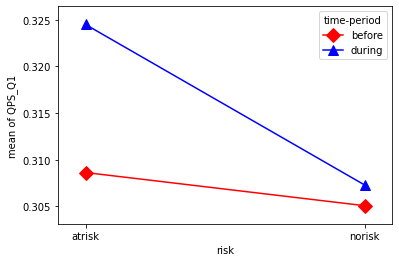

In [ ]:
fig = interaction_plot(df_all['risk'],df_all['time-period'],df_all['QPS_Q1'],
                       colors=['red','blue'], markers=['D','^'], ms=10)
plt.show()

#### QPS_Q2

In [94]:
aov2 = mixed_anova(dv='QPS_Q2', between='risk',
                  within='time-period',subject='user_id', data=df_all)
print(aov2)

        Source        SS  DF1  DF2  ...          F     p-unc       np2  eps
0         risk  0.040038    1  298  ...   0.821293  0.365535  0.002748  NaN
1  time-period  0.046387    1  298  ...  19.381620  0.000015  0.061067  1.0
2  Interaction  0.000561    1  298  ...   0.234474  0.628582  0.000786  NaN

[3 rows x 9 columns]


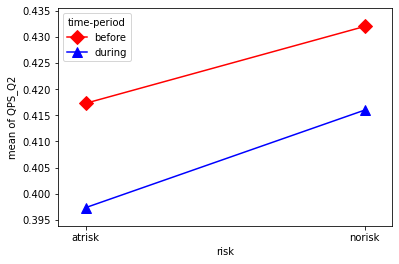

In [ ]:
fig = interaction_plot(df_all['risk'],df_all['time-period'],df_all['QPS_Q2'],
                       colors=['red','blue'], markers=['D','^'], ms=10)
plt.show()

#### QPS_Q3

In [95]:
aov3 = mixed_anova(dv='QPS_Q3', between='risk',
                  within='time-period',subject='user_id', data=df_all)
print(aov3)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  eps
0         risk  0.002698    1  298  0.002698  0.093034  0.760568  0.000312  NaN
1  time-period  0.005211    1  298  0.005211  1.641407  0.201129  0.005478  1.0
2  Interaction  0.000687    1  298  0.000687  0.216258  0.642246  0.000725  NaN


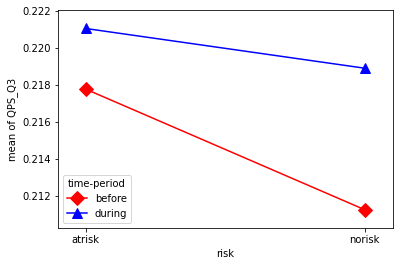

In [ ]:
fig = interaction_plot(df_all['risk'],df_all['time-period'],df_all['QPS_Q3'],
                       colors=['red','blue'], markers=['D','^'], ms=10)
plt.show()

#### QPS_Q4

In [96]:
aov4 = mixed_anova(dv='QPS_Q4', between='risk',
                  within='time-period',subject='user_id', data=df_all)
print(aov4)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  eps
0         risk  0.000557    1  298  0.000557  0.196168  0.658154  0.000658  NaN
1  time-period  0.002407    1  298  0.002407  5.202861  0.023255  0.017160  1.0
2  Interaction  0.001024    1  298  0.001024  2.212826  0.137925  0.007371  NaN


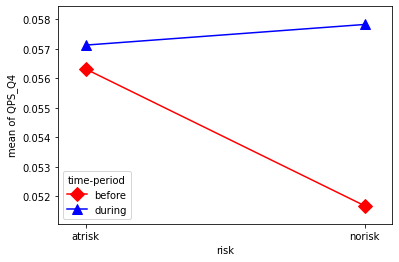

In [ ]:
fig = interaction_plot(df_all['risk'],df_all['time-period'],df_all['QPS_Q4'],
                       colors=['red','blue'], markers=['D','^'], ms=10)
plt.show()

#### Repetitiveness Index

In [97]:
aov5 = mixed_anova(dv='repetitiveness_index', between='risk',
                  within='time-period',subject='user_id', data=df_all)
print(aov5)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  eps
0         risk  0.038613    1  298  0.038613  0.192934  0.660805  0.000647  NaN
1  time-period  0.028721    1  298  0.028721  0.411317  0.521795  0.001378  1.0
2  Interaction  0.071760    1  298  0.071760  1.027691  0.311524  0.003437  NaN


#### Total Session

In [98]:
aov6 = mixed_anova(dv='total_session', between='risk',
                  within='time-period',subject='user_id', data=df_all)
print(aov6)

        Source             SS  DF1  DF2  ...          F     p-unc       np2  eps
0         risk  309191.602500    1  298  ...  14.331535  0.000185  0.045886  NaN
1  time-period   18603.801667    1  298  ...   4.584683  0.033070  0.015152  1.0
2  Interaction     777.480278    1  298  ...   0.191601  0.661905  0.000643  NaN

[3 rows x 9 columns]


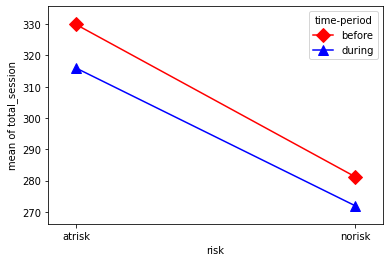

In [ ]:
fig = interaction_plot(df_all['risk'],df_all['time-period'],df_all['total_session'],
                       colors=['red','blue'], markers=['D','^'], ms=10)
plt.show()

#### Total Tracks

In [99]:
aov7 = mixed_anova(dv='total_tracks', between='risk',
                  within='time-period',subject='user_id', data=df_all)
print(aov7)

        Source            SS  DF1  DF2  ...         F     p-unc       np2  eps
0         risk  1.728997e+08    1  298  ...  3.310626  0.069837  0.010987  NaN
1  time-period  2.521500e+05    1  298  ...  0.023497  0.878276  0.000079  1.0
2  Interaction  1.407500e+05    1  298  ...  0.013116  0.908899  0.000044  NaN

[3 rows x 9 columns]


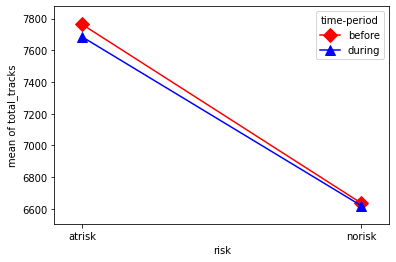

In [ ]:
fig = interaction_plot(df_all['risk'],df_all['time-period'],df_all['total_tracks'],
                       colors=['red','blue'], markers=['D','^'], ms=10)
plt.show()

#### Inertia of QPS_Q1

In [100]:
aov8 = mixed_anova(dv='QPS_Q1_auto', between='risk',
                  within='time-period',subject='user_id', data=df_all)
print(aov8)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  eps
0         risk  0.019885    1  298  0.019885  1.481756  0.224463  0.004948  NaN
1  time-period  0.036931    1  298  0.036931  4.475369  0.035216  0.014796  1.0
2  Interaction  0.001066    1  298  0.001066  0.129133  0.719587  0.000433  NaN


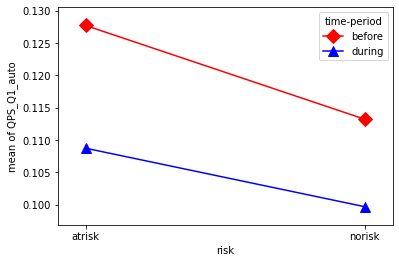

In [123]:
fig = interaction_plot(df_all['risk'],df_all['time-period'],df_all['QPS_Q1_auto'],
                       colors=['red','blue'], markers=['D','^'], ms=10)
plt.show()

#### Inertia of QPS_Q2

In [101]:
aov9 = mixed_anova(dv='QPS_Q2_auto', between='risk',
                  within='time-period',subject='user_id', data=df_all)
print(aov9)

        Source        SS  DF1  DF2  ...         F     p-unc           np2  eps
0         risk  0.000001    1  298  ...  0.000069  0.993370  2.321004e-07  NaN
1  time-period  0.004933    1  298  ...  0.668367  0.414275  2.237823e-03  1.0
2  Interaction  0.005321    1  298  ...  0.720916  0.396525  2.413342e-03  NaN

[3 rows x 9 columns]


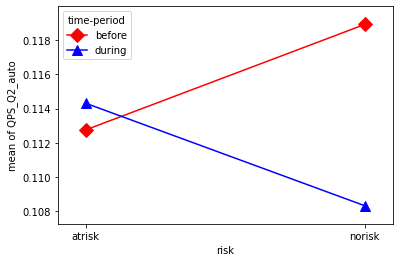

In [127]:
fig = interaction_plot(df_all['risk'],df_all['time-period'],df_all['QPS_Q2_auto'],
                       colors=['red','blue'], markers=['D','^'], ms=10)
plt.show()

#### Inertia of QPS_Q3

In [102]:
aov10 = mixed_anova(dv='QPS_Q3_auto', between='risk',
                  within='time-period',subject='user_id', data=df_all)
print(aov10)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  eps
0         risk  0.000011    1  298  0.000011  0.000651  0.979659  0.000002  NaN
1  time-period  0.021393    1  298  0.021393  2.284421  0.131739  0.007608  1.0
2  Interaction  0.043254    1  298  0.043254  4.618945  0.032426  0.015263  NaN


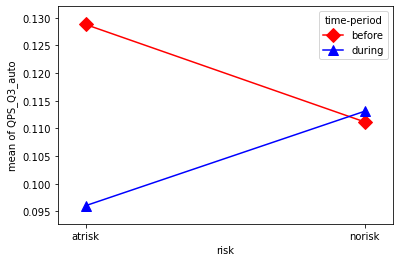

In [125]:
fig = interaction_plot(df_all['risk'],df_all['time-period'],df_all['QPS_Q3_auto'],
                       colors=['red','blue'], markers=['D','^'], ms=10)
plt.show()

#### Inertia of QPS_Q4

In [103]:
aov11 = mixed_anova(dv='QPS_Q4_auto', between='risk',
                  within='time-period',subject='user_id', data=df_all)
print(aov11)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  eps
0         risk  0.000505    1  298  0.000505  0.037109  0.847375  0.000125  NaN
1  time-period  0.035776    1  298  0.035776  3.272817  0.071444  0.010863  1.0
2  Interaction  0.007993    1  298  0.007993  0.731228  0.393172  0.002448  NaN


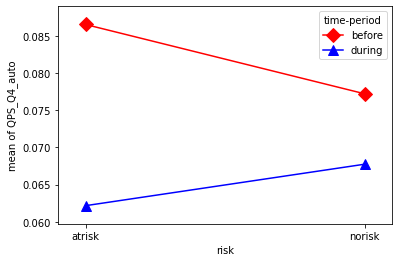

In [126]:
fig = interaction_plot(df_all['risk'],df_all['time-period'],df_all['QPS_Q4_auto'],
                       colors=['red','blue'], markers=['D','^'], ms=10)
plt.show()